# Building a vectorized text data set and fitting machine learning classifiers

### Read in & clean text

In [1]:
import nltk
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string

stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

#read in data - note- may need to add encoding argument or manually change encoding in excel/notepad
data = pd.read_csv("AllReviews2.csv")
#data.columns = ['label', 'body_text']

#Create punctuation percentage feature
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

data['body_len'] = data['Review'].apply(lambda x: len(x) - x.count(" "))
data['punct%'] = data['Review'].apply(lambda x: count_punct(x))

#clean text
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text
 
#Vectorize text
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
X_tfidf = tfidf_vect.fit_transform(data['Review'])
X_features = pd.concat([data['body_len'], data['punct%'], pd.DataFrame(X_tfidf.toarray())], axis=1)
X_features.head()


,body_len,punct%,0,1,2,3,4,5,6,7,...,8439,8440,8441,8442,8443,8444,8445,8446,8447,8448
0,301,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,256,4.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,427,3.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,161,3.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,209,2.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
#get column headers
X_tfidf.columns = tfidf_vect.get_feature_names()
X_tfidf.columns[0:4]

['', '0', '007', '052918']

In [3]:
X_features2 = pd.DataFrame(X_tfidf.toarray())

In [4]:
X_features2.columns = X_tfidf.columns

In [5]:
X_features3 = pd.concat([data['body_len'], data['punct%'], X_features2], axis=1)
X_features3 = X_features3.rename(columns = {'fit': 'fit_feature'})
X_features3.head(2)

,body_len,punct%,,0,007,052918,0900,091618the,0believ,0instead,...,zerobal,zhiska,zika,zit,zoe,zola,zone,zoneunless,zulma,ƒ
0,301,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,256,4.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Explore RandomForestClassifier through Holdout Set

In [57]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_features3, data['IAE'], test_size=0.25, random_state = 15)

In [8]:
#Instantiate and fit random forest model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000, max_depth=25, n_jobs=-1)
rf_model = rf.fit(X_train, y_train)

In [9]:
#get most significant features
sorted(zip(rf_model.feature_importances_, X_train.columns), reverse=True)[0:10]

[(0.083417110641470435, 'body_len'),
 (0.017202931215978923, 'nail'),
 (0.015705387971354789, 'go'),
 (0.014308475461961751, 'back'),
 (0.013421457890413144, 'salon'),
 (0.013317405497464062, 'recommend'),
 (0.012401688563446291, 'massag'),
 (0.012170417152008903, 'best'),
 (0.012012461328894683, 'hair'),
 (0.011264087958185436, 'relax')]

In [10]:
#instantiate evaluation metrics
y_pred = rf_model.predict(X_test)
precision, recall, fscore, support = score(y_test, y_pred, pos_label=1, average='binary')

In [11]:
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3),
                                                        round(recall, 3),
                                                        round((y_pred==y_test).sum() / len(y_pred),3)))

Precision: 0.917 / Recall: 0.965 / Accuracy: 0.939


In [13]:
#print accuracy
from sklearn import metrics
print("Accuracy", metrics.accuracy_score(y_test, y_pred))

Accuracy 0.938733125649


In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

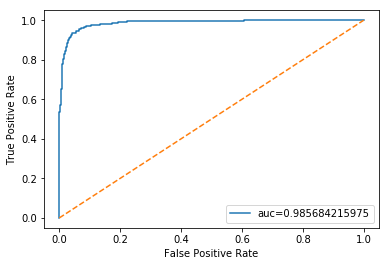

In [60]:
#Plot ROC curve
y_pred_proba = rf_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend(loc=4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [18]:
# Print AUC
import numpy as np
auc = np.trapz(tpr,fpr)
print('AUC:', auc)

AUC: 0.985684215975


In [25]:
#tried new package. didnt work
#import scikitplot as skplt
#y_true = y_test  # ground truth labels
#y_probas = y_pred_proba # predicted probabilities generated by sklearn classifier
#y_probas.reshape(len(y_probas),1)
#skplt.metrics.plot_roc(y_true, y_probas)
#plt.show()

In [38]:
# Get log loss
from sklearn.metrics import log_loss
rf_probs = rf_model.predict_proba(X_test)
score = log_loss(y_test, rf_probs)
print(score)

0.276557793969


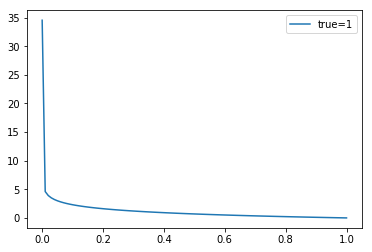

In [42]:
#plot log loss
from numpy import array
# predictions as 0 to 1 in 0.01 increments
yhat = [x*0.01 for x in range(0, 101)]
# evaluate predictions for a 0 true value
losses_0 = [log_loss([0], [x], labels=[0,1]) for x in yhat]
# evaluate predictions for a 1 true value
losses_1 = [log_loss([1], [x], labels=[0,1]) for x in yhat]
# plot input to loss
#plt.plot(yhat, losses_0, label='true=0')
plt.plot(yhat, losses_1, label='true=1')
plt.legend()
plt.show()

In [61]:
# Instantiate and fit Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [62]:
# Logistic Regression: Assess Performance of model
yLogRegPred = logreg.predict(X_test)
precision2, recall2, fscore2, support2 = score(y_test, yLogRegPred, pos_label=1, average='binary')
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision2, 3),
                                                        round(recall2, 3),
                                                        round((yLogRegPred==y_test).sum() / len(yLogRegPred),5)))

Precision: 0.934 / Recall: 0.965 / Accuracy: 0.94808


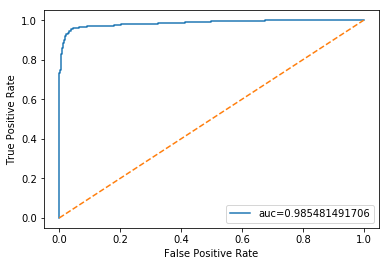

In [65]:
#ROC curve
y_pred_probalr = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_probalr)
auc = metrics.roc_auc_score(y_test, y_pred_probalr)
plt.plot(fpr,tpr,label="auc="+str(auc))
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend(loc=4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [63]:
import sklearn.metrics

In [64]:
# Confusion matrix for Logistic regression
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(y_test, yLogRegPred)
cm2[0][0]+cm2[1][1]

913

In [24]:
cm2

array([[449,  33],
       [ 17, 464]])

In [25]:
#Random Forest confusion matrix
cm1 = confusion_matrix(y_test, y_pred)
cm1

array([[440,  42],
       [ 16, 465]])

In [48]:
from sklearn import svm

In [49]:
#Fit support vector machine algorithm
SupVM = svm.SVC(kernel='linear') # Linear Kernel
SupVM.fit(X_train, y_train)
ySupVM = SupVM.predict(X_test)

In [58]:
#Assess SVM performance
precision3, recall3, fscore3, support3 = score(y_test, ySupVM, pos_label=1, average='binary')
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision3, 3),
                                                        round(recall3, 3),
                                                        round((ySupVM==y_test).sum() / len(ySupVM),5)))

Precision: 0.955 / Recall: 0.973 / Accuracy: 0.96366


In [55]:
#SVM confusion matrix
cm3 = confusion_matrix(y_test, ySupVM)
cm3

array([[460,  22],
       [ 13, 468]])

In [59]:
#ROC curve SVM - not currently working
y_pred_probaSVM = SupVM.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_probaSVM)
auc = metrics.roc_auc_score(y_test, y_pred_probaSVM)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend(loc=4)
plt.show()

AttributeError: predict_proba is not available when  probability=False

In [30]:
#Fit GB model and predict on test
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=150, max_depth=11)
gb_model = gb.fit(X_train, y_train)
ygb = gb_model.predict(X_test)

In [31]:
#Assess GB model performance
precision4, recall4, fscore4, support4 = score(y_test, ygb, pos_label=1, average='binary')
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision4, 3),
                                                        round(recall4, 3),
                                                        round((ygb==y_test).sum() / len(ygb),5)))

Precision: 0.937 / Recall: 0.956 / Accuracy: 0.946


In [32]:
#GB model confusion matrix 
cm4 = confusion_matrix(y_test, ygb)
cm4

array([[451,  31],
       [ 21, 460]])

In [33]:
import xgboost as xgb
xgbm = xgb.XGBClassifier()

In [34]:
#Fit XGBoost model
xgbm.fit(X_train, y_train)
yXGBM = xgbm.predict(X_test)

In [57]:
#Assess XGBoost performance
precision5, recall5, fscore5, support5 = score(y_test, yXGBM, pos_label=1, average='binary')
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision5, 3),
                                                        round(recall5, 3),
                                                        round((yXGBM==y_test).sum() / len(yXGBM),5)))

Precision: 0.917 / Recall: 0.96 / Accuracy: 0.93757


In [58]:
#S=XGBoost 
cm5 = confusion_matrix(y_test, yXGBM)
cm5

array([[448,  41],
       [ 19, 453]])